In [1]:
"""
@authors: faurand, chardes, ehagensieker
"""
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import tqdm
import pprint

# in a notebook, load the tensorboard extension, not needed for scripts
%load_ext tensorboard

#load the mnist dataset
(train_ds, test_ds) = tfds.load('Cifar10', split=['train[:75%]', 'test[:25%]'], as_supervised=True)

2022-12-04 18:11:32.233909: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-04 18:11:32.233986: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-04 18:11:32.233994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


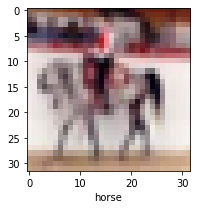

In [2]:
train = list(train_ds)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(3,3))
plt.imshow(train[0][0])
plt.xlabel(class_names[int(train[0][1])])
plt.show()

In [3]:
def prepare_data(batch_size, data): 
    '''
    prepare the dataset to have one-hot-vectors and values between -1 and 1
    '''
    data = data.map(lambda img, target: (tf.cast(img, tf.float32), tf.cast(target,tf.int32)))
    data = data.map(lambda img, target: (img/128.0-1.0,target))
    data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    data = data.cache()
    data = data.shuffle(1000)
    data = data.batch(batch_size)
    data = data.prefetch(tf.data.AUTOTUNE)

    return data

In [4]:
class CNNLayer(tf.keras.layers.Layer):
    def __init__(self, num_filter):
        super(CNNLayer, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters = num_filter, kernel_size = 3, padding = 'same', activation = 'relu')
        
    def call(self, x):
        c = self.conv(x)
        return c
    
class CNNBlock(tf.keras.layers.Layer):
    def __init__(self, num_filter, layers):
        super(CNNBlock, self).__init__()
        self.layers = [CNNLayer(num_filter) for _ in range(layers)]
    
    def call(self,x):
        for layer in self.layers:
            x = layer(x)
            return x

In [5]:
class DenseCNNLayer(tf.keras.layers.Layer):
    def __init__(self, num_filter):
        super(DenseCNNLayer, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters = num_filter, kernel_size = 3, padding = 'same', activation = 'relu')
        
    def call(self, x):
        c = self.conv(x)
        x = tf.concat((x,c),axis=-1)
        return x
    
class DenseCNNBlock(tf.keras.layers.Layer):
    def __init__(self, num_filter, layers):
        super(DenseCNNBlock, self).__init__()
        self.layers = [CNNLayer(num_filter) for _ in range(layers)]
    
    def call(self,x):
        for layer in self.layers:
            x = layer(x)
            return x

In [6]:
class ResidualCNNLayer(tf.keras.layers.Layer):
    def __init__(self, num_filter):
        super(ResidualCNNLayer, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters = num_filter, kernel_size = 3, padding = 'same', activation = 'relu')
        
    def call(self, x):
        c = self.conv(x)
        x = c+x
        return x
    
class ResidualCNNBlock(tf.keras.layers.Layer):
    def __init__(self, num_filter, layers):
        super(ResidualCNNBlock, self).__init__()
        self.deeper_layer = tf.keras.layers.Conv2D(filters=num_filter, kernel_size=3, padding='same', activation='relu')
        self.layers = [CNNLayer(num_filter) for _ in range(layers)]
    
    def call(self,x):
        x = self.deeper_layer(x)
        for layer in self.layers:
            x = layer(x)
            return x

In [7]:
from tensorflow.keras.layers import Dense

class ConvModel(tf.keras.Model):
    '''
    create a deeper network with 4 blocks each having 2 layers and starting with 32 filters in the first layer
    '''
    def __init__(self,optimizer = tf.keras.optimizers.Adam()):
        super(ConvModel, self).__init__()

        self.optimizer = optimizer
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()

        self.metrics_list = [ tf.keras.metrics.Mean(name="loss"),
                            tf.keras.metrics.CategoricalAccuracy(name="acc"),
        ]

        #original input size is 32*32, we have 32 as number of filters
        self.block1 = ResidualCNNBlock(32, 2)
        self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        #after pooling the size is reduced to 16*16
        self.block2 = ResidualCNNBlock(64, 3)
        self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        #after pooling the size is reduced to 8*8
        self.block3 = ResidualCNNBlock(128, 3)
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()

        # one fully connected layer
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        # last layer is a dense layer with softmax activation 
        self.out = tf.keras.layers.Dense(10, activation = 'softmax')

    def call(self, x): 
        x = self.block1(x)
        x = self.pooling1(x)
        x = self.block2(x)
        x = self.pooling2(x)
        x = self.block3(x)
        x = self.global_pool(x)
        x = self.fc1(x)
        x = self.out(x)

        return x

    @property
    def metrics(self):
        return self.metrics_list


    def reset_metric(self):
        for metric in self.metrics:
            metric.reset_states()

    @tf.function 
    def train_step(self, data):
        x, t = data

        with tf.GradientTape() as tape:
            output = self(x, training = True)
            loss = self.loss_function(t, output)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.metrics[0].update_state(loss)

        for metric in self.metrics[1:]:
            metric.update_state(t,output)

        return {metric.name: metric.result() for metric in self.metrics}

    @tf.function
    def test_step(self, data):
        x, t = data

        output = self(x, training = False)
        loss = self.loss_function(t, output)

        self.metrics[0].update_state(loss)
        for metric in self.metrics[1:]:
            metric.update_state(t,output)

        return {metric.name: metric.result() for metric in self.metrics}

In [8]:
def training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer): 
    '''
    create the training loop where the model is trained on the train dataset and afterwards tested on the validation dataset
    '''
    hist = {"train_loss":[],"train_acc":[],"test_loss":[], "test_acc":[]}
    #iterate over given amount of epochs
    for epoch in range(epochs): 
        print(f"Epoch {epoch}: ")

        #train on all batches of the training data
        for data in tqdm.tqdm(train_ds, position = 0, leave = True):
            metrics = model.train_step(data)

            with train_summary_writer.as_default(): 
                for metric in model.metrics: 
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # print the metrics and add to history element
        for key, value in metrics.items():
            hist[f"train_{key}"].append(value.numpy())
            print(f"train_{key}: {value.numpy()}")

        #reset metric 
        model.reset_metrics()

        #evaluation on validation set
        for data in val_ds:
            metrics = model.test_step(data)

            with val_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # print the metrics and add to history element
        for key, value in metrics.items():
            hist[f"test_{key}"].append(value.numpy())
            print(f"test_{key}: {value.numpy()}")

        #reset metric
        model.reset_metric()
        print("\n")
    
    return hist

In [9]:
def create_summary_writers(config_name):
    '''
    create the summary writer to have access to the metrics of the model 
    '''
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    train_log_path = f"logs/tests/{config_name}/{current_time}/train"
    val_log_path = f"logs/tests/{config_name}/{current_time}/val"

    # log writer
    train_summary_writer = tf.summary.create_file_writer(train_log_path)
    val_summary_writer = tf.summary.create_file_writer(val_log_path)

    return train_summary_writer, val_summary_writer

In [10]:
import matplotlib.pyplot as plt 
def run(model):
    '''
    run the model and specify the number of epochs, batch_size and prepare the training and testing data
    '''

    ### Hyperparameters
    num_epochs = 15
    batch_size = 32
    train = prepare_data(batch_size,train_ds)
    test = prepare_data(batch_size,test_ds)

    train_summary_writer, val_summary_writer = create_summary_writers(config_name = f'RUN')
    hist = training_loop(model,train,test,num_epochs,train_summary_writer, val_summary_writer)
    
    fig, ax = plt.subplots(1,2, figsize=(10,10))

    ax[0].plot(hist['train_acc'], label='train accuracy')
    ax[0].plot(hist['test_acc'], label='test accuracy')
    ax[0].legend()

    ax[1].plot(hist['train_loss'], label='train loss')
    ax[1].plot(hist['test_loss'], label='test loss')
    ax[1].legend();

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 0: 


100%|██████████| 1172/1172 [00:14<00:00, 83.64it/s] 


train_loss: 1.687070608139038
train_acc: 0.3503466546535492
test_loss: 1.3145540952682495
test_acc: 0.5076000094413757


Epoch 1: 


100%|██████████| 1172/1172 [00:06<00:00, 169.89it/s]


train_loss: 1.194753646850586
train_acc: 0.5689866542816162
test_loss: 1.0087833404541016
test_acc: 0.6420000195503235


Epoch 2: 


100%|██████████| 1172/1172 [00:06<00:00, 170.70it/s]


train_loss: 0.9707219004631042
train_acc: 0.6541333198547363
test_loss: 0.8822507262229919
test_acc: 0.6880000233650208


Epoch 3: 


100%|██████████| 1172/1172 [00:06<00:00, 169.95it/s]


train_loss: 0.8186164498329163
train_acc: 0.7108266949653625
test_loss: 0.920491099357605
test_acc: 0.6823999881744385


Epoch 4: 


100%|██████████| 1172/1172 [00:06<00:00, 170.77it/s]


train_loss: 0.7181201577186584
train_acc: 0.7487199902534485
test_loss: 0.7309390902519226
test_acc: 0.7423999905586243


Epoch 5: 


100%|██████████| 1172/1172 [00:06<00:00, 169.25it/s]


train_loss: 0.6316601037979126
train_acc: 0.7788800001144409
test_loss: 0.730984091758728
test_acc: 0.75


Epoch 6: 


100%|██████████| 1172/1172 [00:06<00:00, 169.55it/s]


train_loss: 0.5580097436904907
train_acc: 0.8062133193016052
test_loss: 0.6701480746269226
test_acc: 0.7627999782562256


Epoch 7: 


100%|██████████| 1172/1172 [00:06<00:00, 170.48it/s]


train_loss: 0.4939102232456207
train_acc: 0.8267199993133545
test_loss: 0.7158233523368835
test_acc: 0.7699999809265137


Epoch 8: 


100%|██████████| 1172/1172 [00:06<00:00, 169.84it/s]


train_loss: 0.43505460023880005
train_acc: 0.8460000157356262
test_loss: 0.7938447594642639
test_acc: 0.7688000202178955


Epoch 9: 


100%|██████████| 1172/1172 [00:06<00:00, 170.46it/s]


train_loss: 0.38427266478538513
train_acc: 0.864026665687561
test_loss: 0.7729116678237915
test_acc: 0.7675999999046326


Epoch 10: 


100%|██████████| 1172/1172 [00:06<00:00, 169.90it/s]


train_loss: 0.33890068531036377
train_acc: 0.8795199990272522
test_loss: 0.7659239172935486
test_acc: 0.7635999917984009


Epoch 11: 


100%|██████████| 1172/1172 [00:06<00:00, 169.51it/s]


train_loss: 0.2889866530895233
train_acc: 0.8961066603660583
test_loss: 0.8279606103897095
test_acc: 0.7716000080108643


Epoch 12: 


100%|██████████| 1172/1172 [00:06<00:00, 170.14it/s]


train_loss: 0.25159066915512085
train_acc: 0.909280002117157
test_loss: 0.8631571531295776
test_acc: 0.7648000121116638


Epoch 13: 


100%|██████████| 1172/1172 [00:06<00:00, 168.35it/s]


train_loss: 0.21575860679149628
train_acc: 0.9226400256156921
test_loss: 0.9681366682052612
test_acc: 0.7652000188827515


Epoch 14: 


100%|██████████| 1172/1172 [00:06<00:00, 168.94it/s]


train_loss: 0.1899624615907669
train_acc: 0.930453360080719
test_loss: 0.9285558462142944
test_acc: 0.7832000255584717




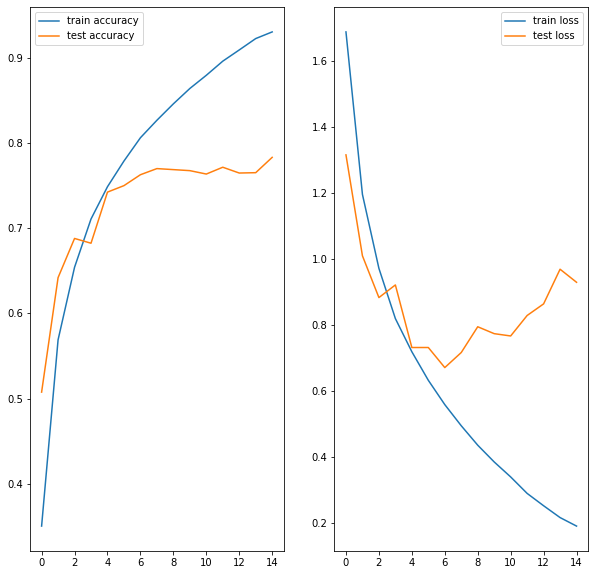

In [11]:
myMod1 = ConvModel(tf.keras.optimizers.Adam(learning_rate=0.001))
hist = run(myMod1)

Regardless of the model architecture we tend to overfit to the trainings data after roughly 7 epochs. To further improve the model we would need to do batch normalization or dropout. 

In [12]:
%tensorboard --logdir logs/tests/